# Contenuti
- [Scikit-image](#Scikit-image)
- [Import delle librerie](#Import-delle-librerie)
- [Caricamento del dataset](#Caricamento-del-dataset)
- [Classificazione a partire dai pixel](#Classificazione-a-partire-dai-pixel)
- [Estrazione delle feature (HOG)](#Estrazione-delle-feature-%28HOG%29)
- [Addestramento del classificatore](#Addestramento-del-classificatore)
- [Esercizio](#Esercizio)
- [Test](#Test)

# Esercitazione 4
Nell'esercitazione odierna si applicheranno diversi algoritmi classici di Machine Learning (*SVM*, *k-NN*, *Random Forest* e *AdaBoost*) a un problema di classificazione binario di **immagini RGB** raffiguranti cani e gatti.

Al fine di manipolare e adattare le immagini verranno utilizzate alcune funzionalità messe a disposizione dalla libreria **Scikit-image**. 

Nel corso dell'esercitazione si dovranno individuare l'algoritmo e le combinazioni di iperparametri che permettono di massimizzare l’accuratezza sul dataset fornito. A tal fine si faccia riferimento alle tecniche viste nell'ambito dell'esercitazione precedente.

Infine si dovrà verificare l'accuratezza della soluzione trovata sul dataset di test per provarne l’effettiva capacità di generalizzazione.

# Scikit-image
Scikit-image è una libreria Python che mette a disposizione numerose classi e funzionalità per l'elaborazione di immagini.

Condivide con Scikit-learn la facilità d'uso, l'ampia possibilità di parametrizzare le operazioni messe a disposizione e l'integrazione con la libreria Numpy. Allo stesso modo lo stile della documentazione e della API è estremamente simile a quello di Scikit-learn.

Per una lista completa delle funzionalità si rimanda alla [documentazione ufficiale](http://scikit-image.org/docs/stable/).

# Import delle librerie
Per prima cosa è necessario eseguire l'import delle librerie utilizzate durante l'esecitazione. Il modulo necessario per utilizzare la libreria Scikit-image si chiama **skimage**.

In [78]:
%matplotlib inline
import time
import numpy as np
import matplotlib.pyplot as plt
from joblib import Memory
from skimage import feature, color, transform
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split

import ml_utilities
import ml_visualization

# Caricamento del dataset
Il dataset consiste in un insieme di immagini RGB di cani e gatti. Prima di caricarlo è necessario definire:
- il percorso in cui sono memorizzate le immagini dei dataset (*db_path*);
- il percorso di una cartella di lavoro (*exp_path*) dove, durante l'elaborazione, saranno memorizzati file intermedi;
- il path del file contenente la lista delle immagini e relative etichette di classe da utilizzare come training set (*train_filelist*).

Caricamento in corso ...
Caricate 900 immagini in 0.53 s.
Gatti: 509
Cani: 391


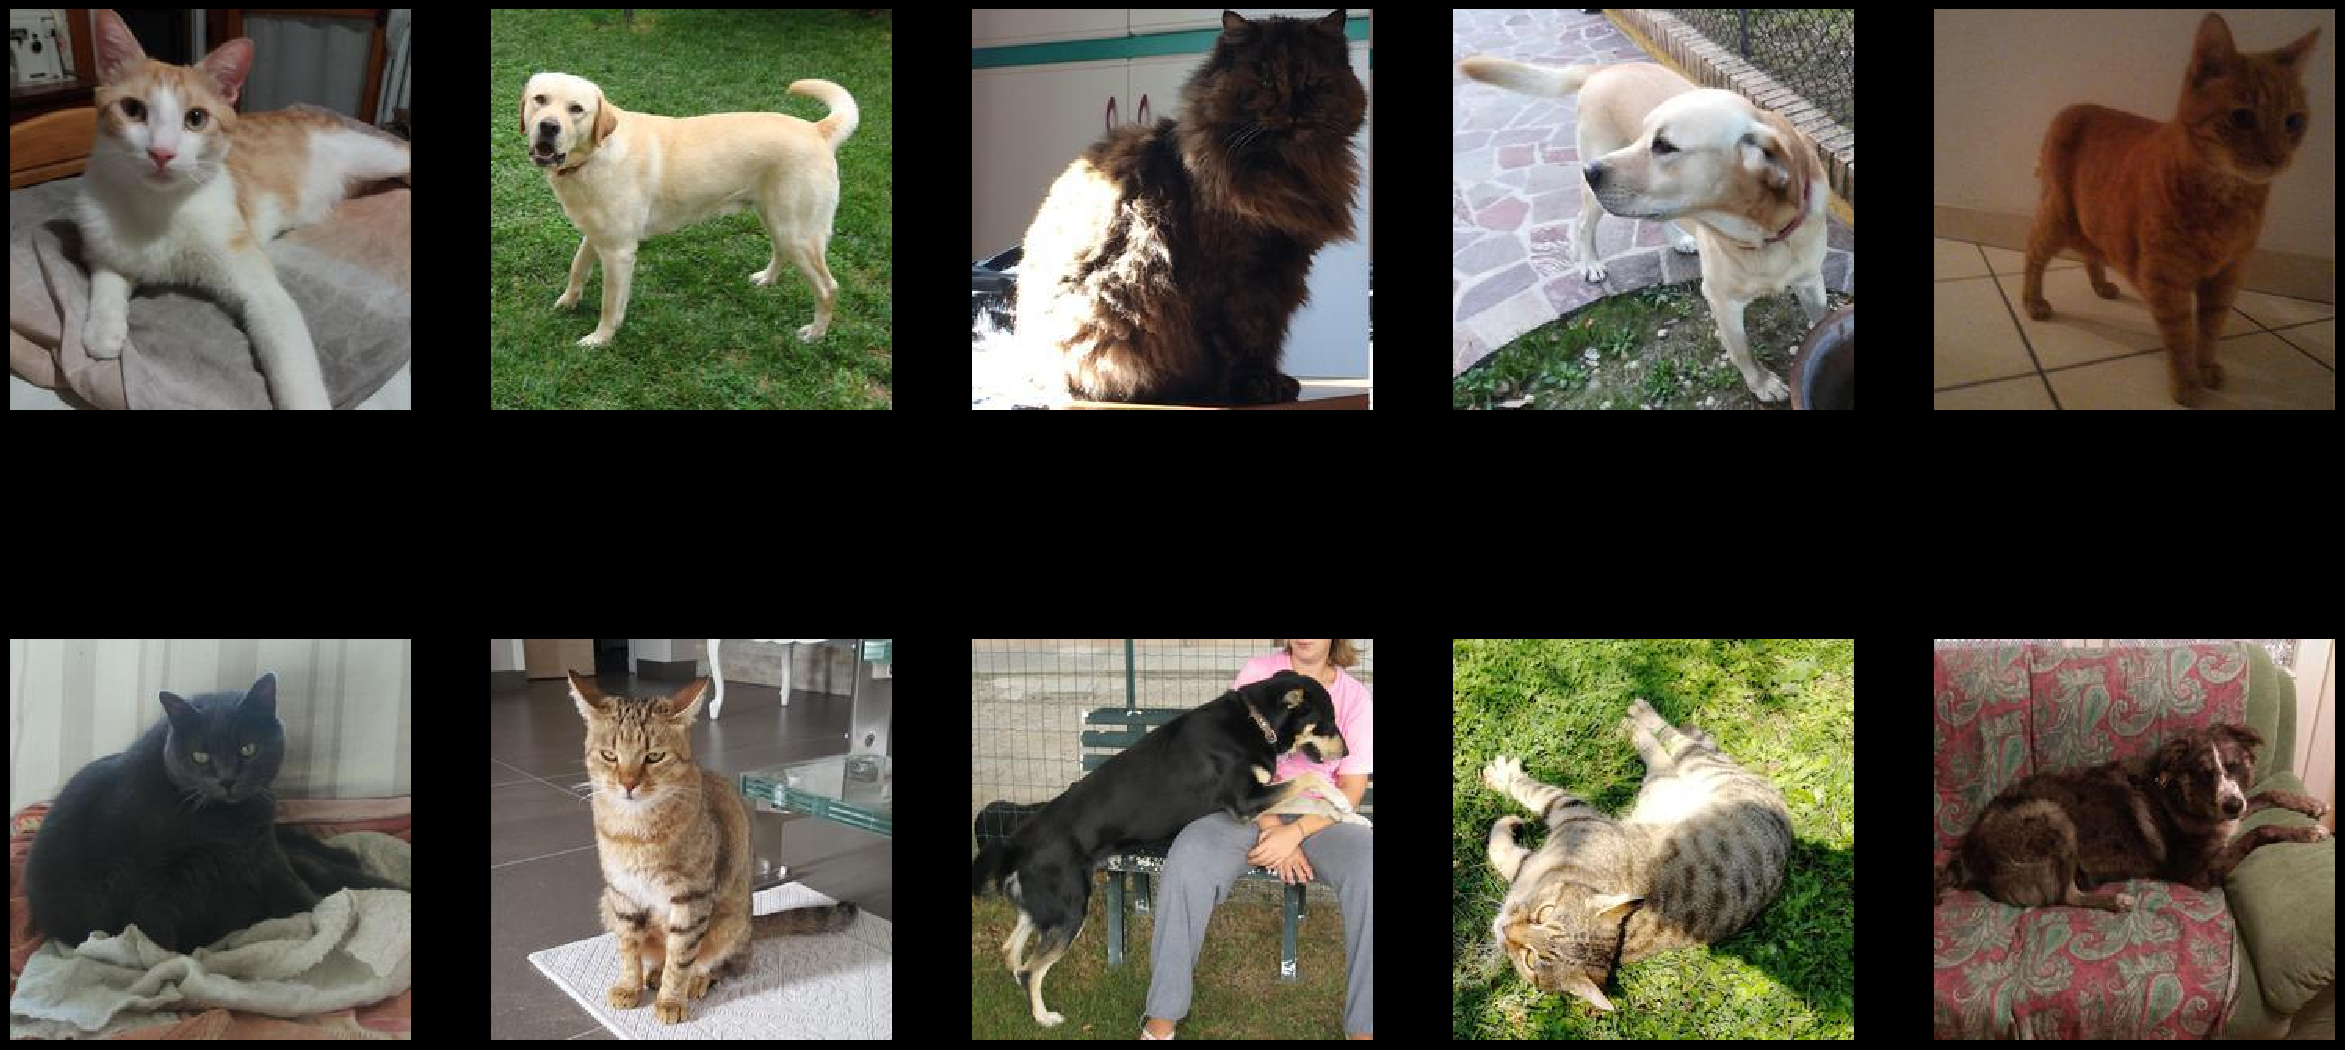

In [79]:
db_path = '../DBs/CaniGatti_ML18'
exp_path = 'Experiments'
train_filelist = 'BinaryTrainingSet.txt'  

# Predisposizione di un'area di caching su disco che velocizza la riesecuzione di chiamate di funzioni con gli stessi parametri
memory = Memory(exp_path, verbose=0)  

# Caricamento delle immagini
print('Caricamento in corso ...')
start = time.time()
train_raw_x, train_y = ml_utilities.load_labeled_dataset(train_filelist, db_path, cache=memory)

print('Caricate %d immagini in %.2f s.' % (len(train_raw_x), time.time() - start))
print('Gatti:', np.count_nonzero(train_y == 0))
print('Cani:', np.count_nonzero(train_y == 1))

# Shuffle del training set
ml_utilities.shuffle_in_unison([train_raw_x, train_y], seed=1234)

# Visualizzazione immagini
_, axs = plt.subplots(2, 5,figsize=(30, 15))
for i in range(5):
    axs[0,i].imshow(train_raw_x[i]),axs[0,i].axis('off')
    axs[1,i].imshow(train_raw_x[5+i]),axs[1,i].axis('off')
plt.show()

Se le dimensioni delle immagini in input sono eterogenee, prima di poterle utilizzare è necessario portarle tutte a delle dimensioni prefissate ($\textit{image\_side} \times \textit{image\_side}$) come mostrato nella cella seguente.

Resizing in corso ...
Resizing completato in 3.66 s.


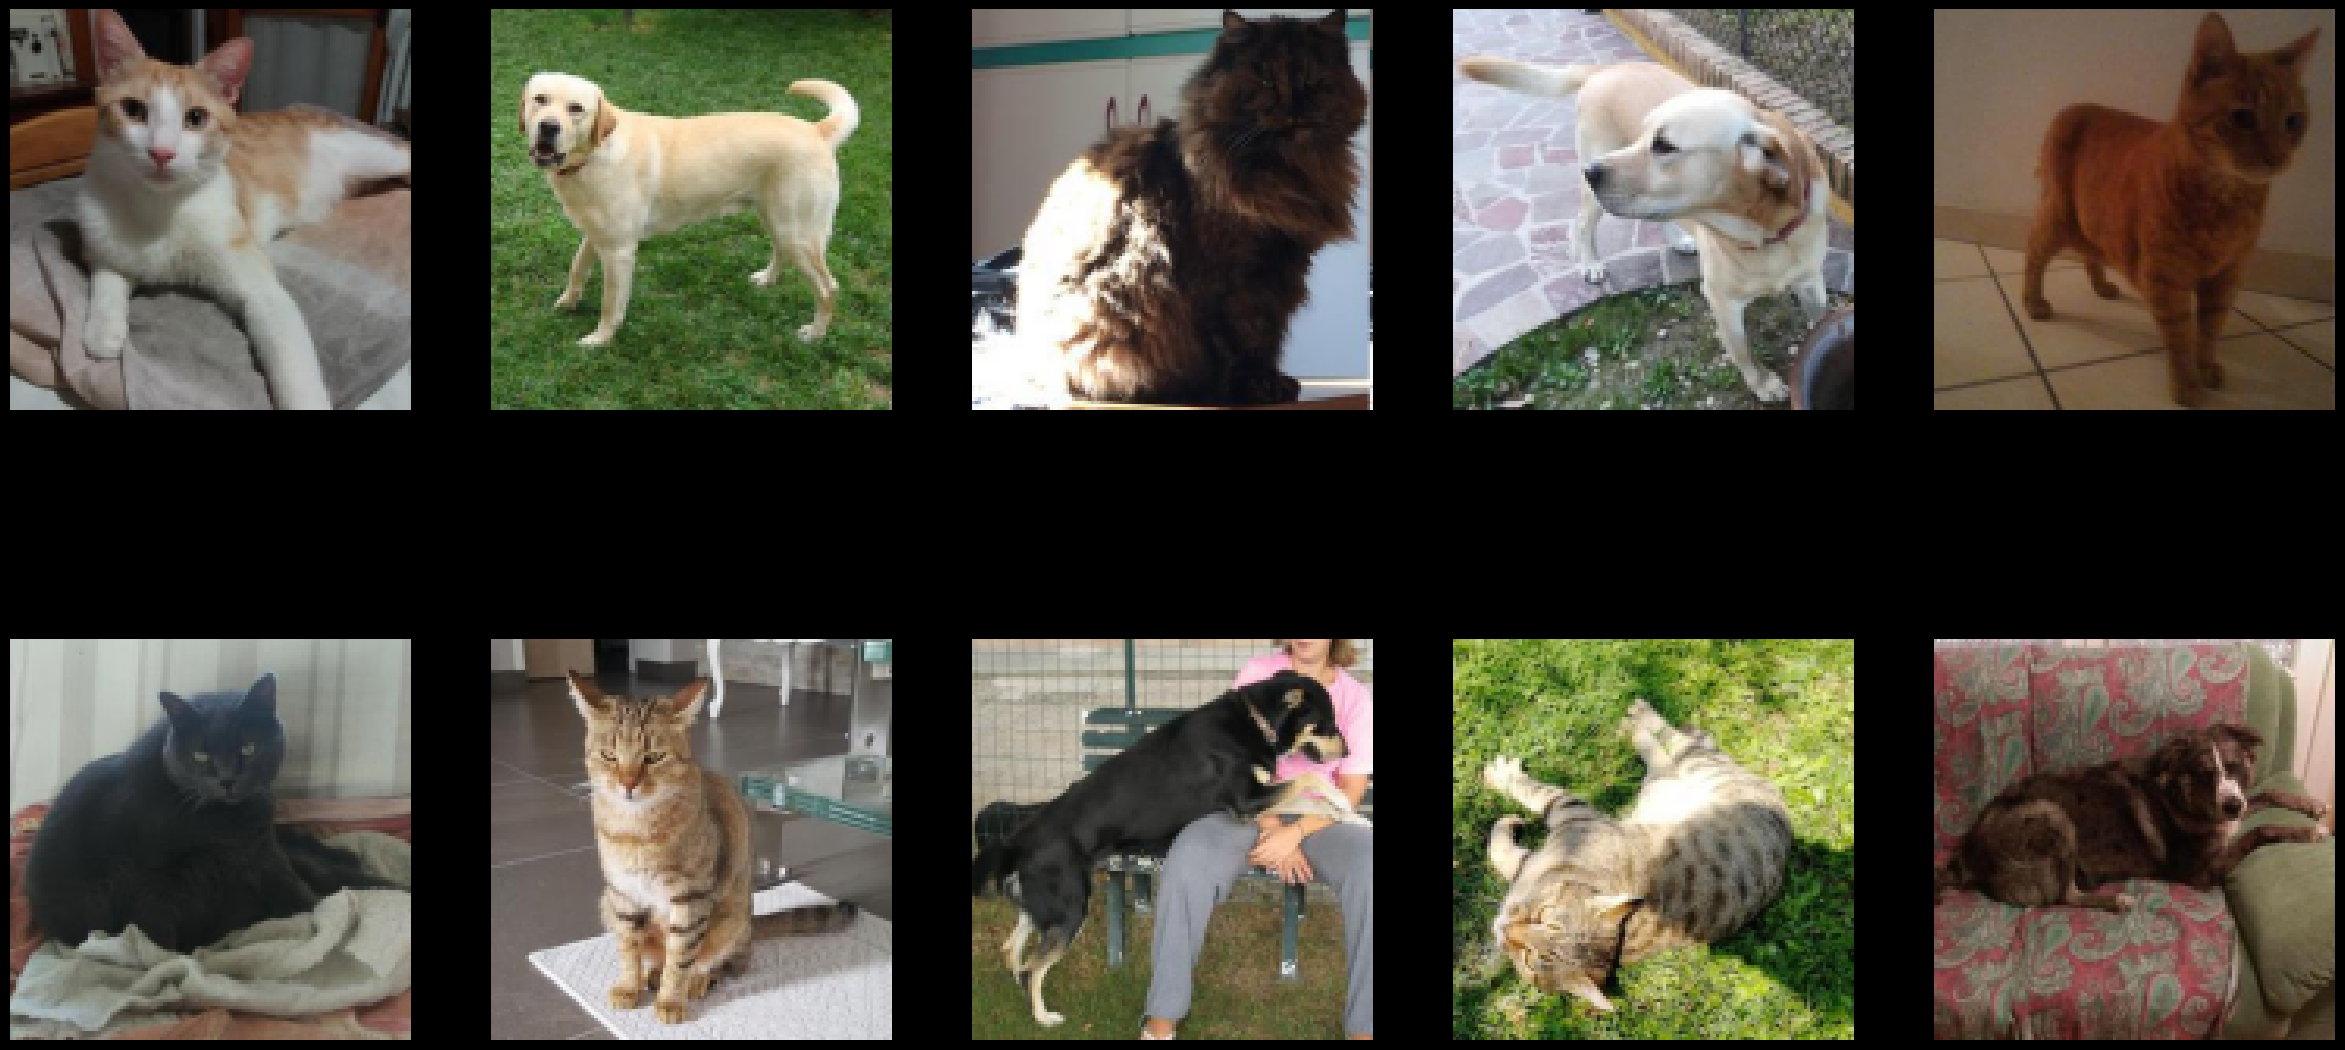

In [80]:
resizing = True
image_side = 128

if resizing:
    # Resize
    print('Resizing in corso ...')
    start = time.time()
    train_raw_x = ml_utilities.resize_images(train_raw_x, image_side, image_side, cache=memory)
    
    print('Resizing completato in %.2f s.' % (time.time() - start))
    
    # Visualizzazione immagini
    _, axs = plt.subplots(2, 5,figsize=(30, 15))
    for i in range(5):
        axs[0,i].imshow(train_raw_x[i]),axs[0,i].axis('off')
        axs[1,i].imshow(train_raw_x[5+i]),axs[1,i].axis('off')
    plt.show()

In [81]:
print("Analisi risoluzioni originali...")
shapes = [img.shape for img in train_raw_x]
areas = np.array([s[0] * s[1] for s in shapes])

# Troviamo un punto di divisione (es. la mediana dell'area)
median_area = np.median(areas)
print(f"Area mediana trovata: {median_area}")

# Creiamo gli indici per i due gruppi
idx_low_res = np.where(areas <= median_area)[0]
idx_high_res = np.where(areas > median_area)[0]

print(f"Trovate {len(idx_low_res)} immagini a bassa risoluzione (originale).")
print(f"Trovate {len(idx_high_res)} immagini ad alta risoluzione (originale).")

if len(idx_high_res) == 0:
    print("ATTENZIONE: Non sono state trovate immagini 'high res'.")
    print("Questo succede se 'train_raw_x' contiene già immagini ridimensionate.")
    print("Esegui 'memory.clear()' e ricarica i dati dall'inizio.")

Analisi risoluzioni originali...
Area mediana trovata: 16384.0
Trovate 900 immagini a bassa risoluzione (originale).
Trovate 0 immagini ad alta risoluzione (originale).
ATTENZIONE: Non sono state trovate immagini 'high res'.
Questo succede se 'train_raw_x' contiene già immagini ridimensionate.
Esegui 'memory.clear()' e ricarica i dati dall'inizio.


# Classificazione a partire dai pixel

Le immagini ottenute (anche a seguito di *resizing*) sono molto grandi per poter essere utilizzate direttamente come input di un classificatore tradizionale. Infatti un'immagine $\textit{128} \times \textit{128} \times \textit{3}$ corrisponde a un pattern 49152-dimensionale.

Utilizzando un *SVM* il tempo di training è di circa 2 minuti (utilizzando la classe **LinearSVC** ottimizzata per *kernel* lineare) per ottenere un'accuratezza intorno al 57% (di poco superiore alla scelta casuale!).

Nel settore della visione artificiale per l'addestramento di classificatori (qualora non si utilizzino tecniche di deep learning quali le reti CNN) è prassi consolidata estrarre dalle immagini feature **robuste** e **compatte**.

Perchè l'intensità dei pixel non è una feature robusta?
<img src="pixel_dist.png" alt="" style="width: 600px;"/>

Variazioni di posa, e illuminazione possono rendere campioni della stessa classe molto diversi tra loro in termini di intensità di pixel corrispondenti.

Purtroppo non esiste un tipo di feature idoneo per tutti i problemi ma è necessario padroneggiare il dominio applicativo per scegliere/progettare in modo ottimale le feature da utilizzare (si parla di *feature engineering* o *handcrafted features*).

# Estrazione delle feature (HOG)
In questa esercitazione utilizzeremo le feature note come *Histogram of Oriented Gradients* ([HOG](https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients)), originariamente introdotte per *pedestrian detection*, ma applicabili anche ad altri domini.

Un'implementazione è disponibile nella libreria  [Scikit-image](http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.hog).

Per estrarre le orientazioni, il metodo HOG non ha evidenti vantaggi dall'uso del colore. Pertanto prima dell'estrazione le immagini possono essere convertite da RGB (3 byte per pixel) in scala di grigi (1 byte per pixel).

L'immagine viene suddivida in blocchi. Per ognuno di essi HOG estrae le orientazioni del gradiente e le riassume attraverso un istogramma. 

La funzione **hog(...)** restituisce un **ndarray** monodimensionale contenente le feature estratte. Con il paramentro opzionale (*visualise*) è possibile ottenerne una visualizzazione grafica utile per comprendere meglio la natura delle feature estratte. La cella seguente visualizza una rappresentazione HOG relativa a un'immagine di esempio.

Numero feature: 15876


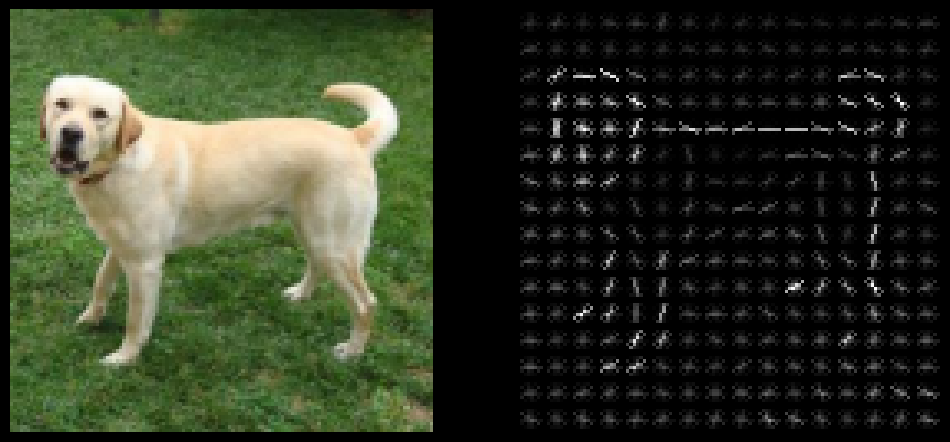

In [82]:
image_index = 1  # Modificare con un indice a piacere

# Conversione in grayscale
grayscale_image = color.rgb2gray(train_raw_x[image_index])

# Estrazione delle feature
hog_features, hog_image = feature.hog(grayscale_image,
                                      orientations=9, pixels_per_cell=(8, 8),
                                      cells_per_block=(3, 3),  block_norm='L2-Hys',
                                      visualize=True)

print('Numero feature:', len(hog_features))

# Visualizzazione HOG
_, axs = plt.subplots(1, 2,figsize=(12, 6))
axs[0].imshow(train_raw_x[image_index]),axs[0].axis('off')
axs[1].imshow(hog_image),axs[1].axis('off')
plt.show()

La procedura appena descritta deve essere applicata a tutte le immagini. Per fare ciò è possibile utilizzare la funzione **extract_hog(...)** del modulo *ml_utilities* come mostrato di seguito:

In [83]:
print('Estrazione delle feature HOG in corso ...')
start = time.time()
train_feature_x = ml_utilities.extract_hog(train_raw_x,
                                           convert_to_gray=True, orientations=9,
                                           pixels_per_cell=(8, 8), cells_per_block=(3, 3),
                                           cache=memory)
print('Estrazione completata in %.2f s.' % (time.time() - start))

Estrazione delle feature HOG in corso ...
Estrazione completata in 0.30 s.


# Addestramento del classificatore
Completata la fase di **estrazione** delle feature, è possibile utilizzarle per addestrare un classificatore.

Il dataset *train_feature_x* e la lista delle etichette di classe *train_y* sono nel formato richiesto dall'API di Scikit-learn.

In Scikit-learn oltre a [*k-NN*](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) e [*SVM*](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) (visti nell'esercitazione precedente) sono presenti anche i classificatori [*Random Forest*](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) e [*AdaBoost*](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html). 

Di seguito vengono riportate le istruzioni necessarie per creare e addestrare un classificatore:

In [84]:
start = time.time()
#clf = KNeighborsClassifier(n_neighbors=5)
clf = SVC()
#clf = RandomForestClassifier(random_state=1234)
#clf = AdaBoostClassifier(random_state=1234)

print('Addestramento in corso ...')
clf.fit(train_feature_x, train_y)
print('Addestramento completato in %.2f s.' % (time.time() - start))

Addestramento in corso ...
Addestramento completato in 3.00 s.


È possibile stimare l'accuratezza di un classificatore utilizzando il metodo **.predict(...)**. Il metodo restituisce le predizioni del classificatore su un insieme di pattern che, confrontate con le etichette reali, permettono di calcolarne l'accuratezza. Ad esempio:

Valutazione sul training set in corso ...
Valutazione sul training set completata in 6.10 s.
Accuratezza: 0.9988888888888889


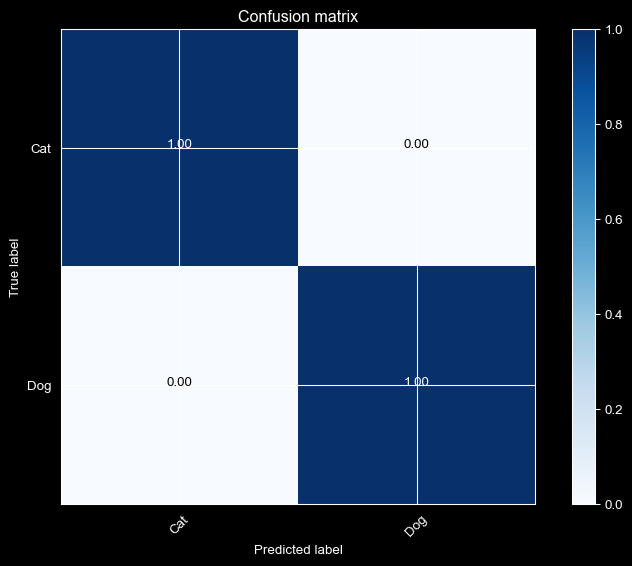

In [85]:
print('Valutazione sul training set in corso ...')
start = time.time()
train_predictions = clf.predict(train_feature_x)
print('Valutazione sul training set completata in %.2f s.' % (time.time() - start))

# Calcolo accuratezza
train_accuracy = (train_predictions == train_y).sum()/len(train_y)
print('Accuratezza:', train_accuracy)

# Visualizzazione Confusion Matrix
ml_visualization.plot_confusion_matrix(train_y, train_predictions, ['Cat', 'Dog'])
#se non la fa vedere aggiungere plt.show()

# Esercizio
L'obiettivo è massimizzare l'accuratezza di classificazione, valutando (con *Cross-Validation*):
- l'impiego di diversi classificatori, come [*k-NN*](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html), [*SVM*](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html), [*Random Forest*](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), [*AdaBoost*](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html) o altri. È possibile utilizzare qualsiasi tipologia di classificatore tranne quelli basati su reti neurali.
- l'ottimizzazione dei relativi iperparametri;
- l'ottimizzazione dei parametri utilizzati per estrarre le feature HOG;
- la combinazione di più classificatori.

Si consiglia di procedere iterativamente a partire da un insieme limitato di combinazioni per poi raffinare la ricerca: infatti, i tempi richiesti per l'esecuzione di [**cross_val_score(...)**](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) e [**GridSearchCV(...)**](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) possono diventare proibitivi per un elevato numero di combinazioni di iperparametri e *fold*.

**NOTA BENE:**
 - Il classificatore dovrà essere **addestrato e testato sulle feature HOG** estratte dai pattern del dataset (quindi non direttamente sulle immagini originali);
 - Non è (ovviamente) possibile utilizzare i pattern del test set per l'addestramento del classificatore;
 - **Non è consentito aggiungere immagini esterne** al training set così come non è possibile utilizzare immagini derivate (*augmentation*).

In [86]:
# print("Estrazione di 3 set di feature HOG (Generale, Medio, Dettagliato)...")
#
# print('Estrazione HOG 8x8...')
# features_list_8x8 = ml_utilities.extract_hog(train_raw_x,
#                                            convert_to_gray=True, orientations=9,
#                                            pixels_per_cell=(8, 8),
#                                            cells_per_block=(3, 3), cache=memory)
# train_feature_x_8x8 = np.array(features_list_8x8)
#
# print('Estrazione HOG 10x10...')
# features_list_10x10 = ml_utilities.extract_hog(train_raw_x,
#                                            convert_to_gray=True, orientations=9,
#                                            pixels_per_cell=(10, 10),
#                                            cells_per_block=(3, 3), cache=memory)
# train_feature_x_10x10 = np.array(features_list_10x10)
#
# print('Estrazione HOG 12x12...')
# features_list_12x12 = ml_utilities.extract_hog(train_raw_x,
#                                            convert_to_gray=True, orientations=9,
#                                            pixels_per_cell=(12, 12),
#                                            cells_per_block=(3, 3), cache=memory)
# train_feature_x_12x12 = np.array(features_list_12x12)
#
# print("Formati delle feature (campioni, n_feature):")
# print(f"HOG 8x8: {train_feature_x_8x8.shape}")
# print(f"HOG 10x10: {train_feature_x_10x10.shape}")
# print(f"HOG 12x12: {train_feature_x_12x12.shape}")

In [87]:
# Cella: Esercizio 1

# Ottimizzazione SVM
print("Ottimizzazione SVM (con probability=True)...")
start = time.time()
param_grid_svm = [{'C': [10], 'gamma': [0.01], 'kernel': ['rbf']}]
grid_search_svm = GridSearchCV(SVC(probability=True, random_state=42), param_grid_svm, cv=5, scoring='accuracy', verbose=1, n_jobs=1)
grid_search_svm.fit(train_feature_x, train_y)
print("-" * 30)

# Ottimizzazione k-NN
print("Ottimizzazione k-NN (su feature 8x8)...")
start = time.time()
param_grid_knn = [{'n_neighbors': [3, 5], 'metric': ['manhattan'], 'weights': ['distance']}]
grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, scoring='accuracy', verbose=1, n_jobs=1)
grid_search_knn.fit(train_feature_x, train_y)
print("-" * 30)

# Ottimizzazione Random Forest
print("Ottimizzazione Random Forest (su feature 8x8)...")
start = time.time()
param_grid_rf = [{'n_estimators': [200], 'max_depth': [None], 'max_features': ['sqrt']}]
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='accuracy', verbose=1, n_jobs=1)
grid_search_rf.fit(train_feature_x, train_y)
print("-" * 30)

# Costruzione e valutazione Ensemble
print("Valutazione Ensemble (VotingClassifier)...")

clf1 = grid_search_svm.best_estimator_
clf2 = grid_search_knn.best_estimator_
clf3 = grid_search_rf.best_estimator_

clf_ensemble = VotingClassifier(
    estimators=[('svm', clf1), ('knn', clf2), ('rf', clf3)],
    voting='soft'
)

scores_ensemble = cross_val_score(clf_ensemble, train_feature_x, train_y, cv=5, scoring='accuracy', n_jobs=1)

print("\n ----- Confronto risultati -----")
print(f"Accuratezza SVM:    {grid_search_svm.best_score_:.4f}")
print(f"Accuratezza k-NN:   {grid_search_knn.best_score_:.4f}")
print(f"Accuratezza RF:     {grid_search_rf.best_score_:.4f}")
print(f"Accuratezza ENSEMBLE: {np.mean(scores_ensemble):.4f}")

Ottimizzazione SVM (con probability=True)...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
------------------------------
Ottimizzazione k-NN (su feature 8x8)...
Fitting 5 folds for each of 2 candidates, totalling 10 fits
------------------------------
Ottimizzazione Random Forest (su feature 8x8)...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
------------------------------
Valutazione Ensemble (VotingClassifier)...

 ----- Confronto risultati -----
Accuratezza SVM:    0.8122
Accuratezza k-NN:   0.7689
Accuratezza RF:     0.7700
Accuratezza ENSEMBLE: 0.8311


# Test
Si addestri il classificatore desiderato utilizzando gli iperparametri trovati nell'esercizio precedente. Il codice contenuto nella cella seguente userà tale classificatore per predire la classe dei pattern del dataset di test. Le classi predette verranno salvate su un file di testo che dovrà essere caricato sul sito della competizione per misurarne l'accuratezza.
Le procedure utilizzate per caricare i dataset, per estrarne le feature e per addestrare il classificatore desiderato dovranno essere riportate nella cella seguente. Ai fini della competizione si ricorda che nel file .zip dovrà essere inclusa anche una cartella "Codice" contenente una copia di questo notebook e degli script Python utilizzati.

In [17]:
#se da errore mettere
#import os
#os.environ['OMP_NUM_THREADS'] = '1'
#va messo all'inizio, prima delle import, usarlo solo in caso di errore perchè rallenta il tutto

In [89]:
# Esercizio 2: valutazione su test set

# Path
image_side = 128
db_path = '../DBs/CaniGatti_ML18'
exp_path = 'Experiments'
train_filelist = 'BinaryTrainingSet.txt'
test_filelist = 'Unlabeled_BinaryTestSet.txt'
result_path = 'Es4Predictions.txt'
memory = Memory(exp_path, verbose=0)

print("Pulizia della cache...")
memory.clear()

# Caricamento dei pattern di training
train_raw_x, train_y = ml_utilities.load_labeled_dataset(train_filelist, db_path, cache=memory)
print(f"Caricati {len(train_raw_x)} pattern di training.")

print("Resizing Training...")
resizing = True

if resizing:
    # Resize
    print('Resizing in corso ...')
    start = time.time()
    train_raw_x = ml_utilities.resize_images(train_raw_x, image_side, image_side, cache=memory)

    print('Resizing completato in %.2f s.' % (time.time() - start))

# Preprocessing ed estrazione HOG (training)
print('Estrazione HOG 8x8 (Training)...')
train_feature_x = np.array(ml_utilities.extract_hog(train_raw_x,
                                           convert_to_gray=True, orientations=9,
                                           pixels_per_cell=(8, 8), cells_per_block=(3, 3),
                                           cache=memory))
print('Estrazione Training completata.')

# # Creazione del classificatore ENSEMBLE
print("Creazione classificatori per l'Ensemble (0.8311)...")

# 1. SVM (probability=True per il 'soft' voting)
clf1 = SVC(C=10, gamma=0.01, kernel='rbf', probability=True, random_state=42)

# 2. k-NN
clf2 = KNeighborsClassifier(n_neighbors=3, metric='manhattan', weights='distance')

# 3. Random Forest
clf3 = RandomForestClassifier(n_estimators=200, max_depth=None, max_features='sqrt', random_state=42)

# Creiamo l'Ensemble (Soft Voting)
clf_ensemble = VotingClassifier(
    estimators=[('svm', clf1), ('knn', clf2), ('rf', clf3)],
    voting='soft'
)

#
# Addestramento del classificatore
print("Addestramento Ensemble (VotingClassifier) sull'intero training set...")
start = time.time()
clf_ensemble.fit(train_feature_x, train_y)
print("Tempo addestramento: %.2f s." % (time.time() - start))

# Caricamento dei pattern di test
print("Caricamento Test Set...")
test_raw_x = ml_utilities.load_unlabeled_dataset(test_filelist, db_path, cache=memory)

print("Resizing Test...")
if resizing:
    # Resize
    print('Resizing in corso ...')
    start = time.time()
    test_raw_x = ml_utilities.resize_images(test_raw_x, image_side, image_side, cache=memory)

    print('Resizing completato in %.2f s.' % (time.time() - start))

#Preprocessing ed estrazione HOG (test)
print('Estrazione HOG 8x8 (Test)...')
test_feature_x = np.array(ml_utilities.extract_hog(test_raw_x,
                                          convert_to_gray=True, orientations=9,
                                          pixels_per_cell=(8, 8), cells_per_block=(3, 3),
                                          cache=memory))
print('Estrazione Test completata.')

# Salvataggio delle predictions
print("Predizione sul Test Set (con Ensemble)...")
predictions = clf_ensemble.predict(test_feature_x)

with open(result_path, "w") as f:
    for prediction in predictions:
        f.write(str(int(prediction)) + '\n')
print('Ok')
print(f"Risultati salvati in: {result_path}")

[Memory(location=Experiments/joblib)]: Flushing completely the cache


Pulizia della cache...
Caricati 900 pattern di training.
Resizing Training...
Resizing in corso ...
Resizing completato in 4.12 s.
Estrazione HOG 8x8 (Training)...
Estrazione Training completata.
Creazione classificatori per l'Ensemble (0.8311)...
Addestramento Ensemble (VotingClassifier) sull'intero training set...
Tempo addestramento: 26.28 s.
Caricamento Test Set...
Resizing Test...
Resizing in corso ...
Resizing completato in 0.61 s.
Estrazione HOG 8x8 (Test)...
Estrazione Test completata.
Predizione sul Test Set (con Ensemble)...
Ok
Risultati salvati in: Es4Predictions.txt
